In [1]:
# sys, file and nav packages:
import os
import datetime as dt
import csv
import json

# math packages:
import pandas as pd
import numpy as np
from scipy import stats

import datetime as dt 
from scipy.stats import kendalltau, pearsonr, spearmanr
import math
from scipy.stats import gamma
from scipy.stats import beta
from scipy.stats import binom
from scipy.stats import bernoulli
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples
from statsmodels.distributions.empirical_distribution import ECDF
# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
import matplotlib.ticker as mtick
import seaborn as sns
from matplotlib.gridspec import GridSpec
from IPython.display import display, Markdown, Latex, HTML
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, Colormap

# mapping
import geopandas as gpd

# home brew utitilties
import utilities.utility_functions as ut
import utilities.abundance_classes as ac

# documenting
from IPython.display import Markdown as md


# returns the p_value for each test
def kendall_pval(x,y):
    return kendalltau(x,y)[1]

def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]

def spearmanr_pval(x,y):
    return spearmanr(x,y)[1]

def use_this_key(x, key, column='no column'):
    this_type = type(key)
    if type(x) == tuple:
        x = [x]
    else:
        pass
    if this_type == dict:
        try:
            data = key[x]
        except:
            data = 'no data'
    elif this_type == pd.core.series.Series:
        try:
            data =key.loc[x]
        except:
            data='no data'
    else:
        try:
            data = key.loc[x, column][0]        
        except:
            data='no data'
    
    return data
    

# table kwargs
table_k = dict(loc="top left", bbox=(0,0,1,1), colWidths=[.5, .5], cellLoc='center')
tablecenter_k = dict(loc="top left", bbox=(0,0,1,1), cellLoc='center')
tabtickp_k = dict(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False)

# chart kwargs
title_k = {'loc':'left', 'pad':14, 'linespacing':1.5, 'fontsize':12}
title_k14 = {'loc':'left', 'pad':16, 'linespacing':1.5, 'fontsize':14}
xlab_k = {'labelpad':10, 'fontsize':12}
xlab_k14 = {'labelpad':14, 'fontsize':14}


# # use these to format date axis in charts
# weeks = mdates.WeekdayLocator(byweekday=1, interval=4)
# # onedayweek = mdates.DayLocator(bymonthday=1, interval=1)
# # everytwoweeks = mdates.WeekdayLocator(byweekday=1, interval=4)

# months = mdates.MonthLocator(bymonth=[3,6,9,12])
# bimonthly = mdates.MonthLocator(bymonth=[1,3,5,7,9,11])
# allmonths = mdates.MonthLocator()
# wks_fmt = mdates.DateFormatter('%d')
# mths_fmt = mdates.DateFormatter('%b')

display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))

# map marker size:

survey_data, location_data, code_defs, stat_ent, geo_data, output = ut.make_local_paths()

In [2]:
# set some parameters:
start_date = '2020-04-01'
end_date ='2021-04-01'

startyearmonth = '{}/{}'.format(start_date[5:7], start_date[:4])
endyearmonth = '{}/{}'.format(end_date[5:7], end_date[:4]) 


# define a significant event:
sig = .9
one_minus_sig = (1-sig)

# define explanatory variables:
# expv = ['population','streets','buildings','rivs']

# name the folder:
name_of_project = 'bielsummary'
save_output = False

# use this to store things:
project_directory = ut.make_project_folder(output, name_of_project)


# keep track of output
files_generated = []
figure_num = 1
data_num = 1
def make_a_group_summary(adf, groups={}, aggs={}):
    som_data = adf.groupby(groups['columns'], as_index=False).agg(aggs)
    a_quantity = som_data.groupby(groups['quantity_level']).quantity.sum()
    return som_data, a_quantity

def calculate_rates(adf, feature_total_map=None, feature_map=None, groups=None, aggs=None, rates=None, products=None, methods=None):
    fgs=adf.copy()
    if groups != None:
        fgs = adf.groupby(groups['columns'], as_index=False).agg(aggs)
        a_list_of_features = adf[groups['quantity_level']].unique()
        for this_feature in a_list_of_features:
            fgs.loc[fgs[groups['quantity_level']]==this_feature, 'feature_total'] = feature_total_map(this_feature, feature_map)
    if rates:
        for rate in rates:
            fgs[rate['rate_name']] = fgs[rate['columns']['this']]/fgs[rate['columns']['over_that']]
    if products:
        for product in products:
            fgs[product['rate_name']]= fgs[product['columns']['this']]*fgs[product['columns']['times_that']]
            
    return fgs
def make_heat_map_data(data, cols=[], columns=[], index=None, sort_values=None):
    new_data = data[cols].pivot(index=index, columns=columns, values=cols[-1])
    if sort_values != None:
        new_data.sort_values(by=sort_values, inplace=True, ascending=False)
    if isinstance(new_data.columns, pd.MultiIndex) == True:
        new_data.columns = new_data.columns.get_level_values(1)
    
    return new_data.astype(float)

def add_output(**kwargs):
    files_generated.append({'tag':kwargs['tag'], 'number':kwargs['figure_num'], 'file':kwargs['file'],'type':kwargs['a_type']})
    if kwargs['a_type'] == 'data':
        kwargs['data'].to_csv(F"{kwargs['file']}.csv", index=False)
    else:
        plt.savefig(F"{kwargs['file']}.jpeg", dpi=300)


In [3]:
# non aggregated survey data
# Zero values are assigned for all codes not identified at a survey, for each survey
dfSurveys = pd.read_csv(F"{survey_data}/results_with_zeroes.csv")

# house keeping
dfSurveys = dfSurveys[(dfSurveys.date >= start_date)&(dfSurveys.date <= end_date)]
dfSurveys['date'] = pd.to_datetime(dfSurveys['date'], format="%Y-%m-%d")

# river bassin labels
with open(F"{location_data}/river_basins.json", "r") as a_file:
    river_bassins=json.load(a_file)

# beach data
dfBeaches = pd.read_csv(F"{location_data}/beaches_with_ranks.csv")
dfBeaches.set_index('slug', inplace=True)

# assign river bassin labels to locations:
for k,v in river_bassins.items():
    dfBeaches.loc[dfBeaches.water_name_slug.isin(v), 'river_bassin'] = k

# code definitions
dfCodes = pd.read_csv(F"{code_defs}/mlw_codes.csv", index_col='code')

# dimensional data
dfDims = pd.read_csv(F"{survey_data}/dims_data.csv")

# project lakes and beaches:
with open(F"{location_data}/project_lakes.json", "r") as a_file:
    project_lakes = json.load(a_file)

with open(F"{location_data}/project_beaches.json", "r") as a_file:
    project_beaches = json.load(a_file)
    
print(F"\nThese are the project beaches:\n\n{project_beaches}\n")
print(F"\nThese are the project lakes:\n\n{project_lakes}\n")


These are the project beaches:

['neuenburgersee_cudrefin_mattera', 'la-petite-plage', 'evole-plage', 'plage-de-cheyres', 'mullermatte', 'bielersee_vinelz_fankhausers', 'baby-plage-geneva', 'baye-de-montreux-g', 'grand-clos', 'preverenges', 'quai-maria-belgia', 'zurichsee_wollishofen_langendorfm', 'zurichsee_kusnachterhorn_thirkell-whitej', 'zuerichsee_richterswil_benkoem_2', 'rastplatz-stampf', 'weissenau-neuhaus', 'thunersee_spiez_meierd_1', 'walensee_walenstadt_wysse', 'gasi-strand', 'vira-gambarogno', 'sentiero-giro-del-golf-spiaggia', 'maladaire']


These are the project lakes:

['Bielersee', 'Walensee', 'Zurichsee', 'Lac Léman', 'Thunersee', 'Neuenburgersee', 'Lago Maggiore']



In [4]:
dfBeaches.water_name_slug.unique()

array(['zurichsee', 'aare', 'aarenidau-buren-kanal', 'lac-leman', 'arve',
       'lago-maggiore', 'thunersee', 'untersee', 'bielersee', 'birs',
       'bodensee', 'ticino', 'chriesbach', 'neuenburgersee', 'emme',
       'walensee', 'glatt', 'goldach', 'greifensee', 'grandelbach',
       'brienzersee', 'inn', 'jona', 'katzensee', 'dorfbach', 'la-thiele',
       'langeten', 'rhone', 'limmat', 'linthkanal', 'escherkanal',
       'lorze', 'lotschebach', 'murg', 'ognonnaz', 'pfaffnern', 'reuss',
       'rhein', 'maggia', 'schiffenensee', 'schuss', 'seez', 'sempachsee',
       'sense', 'sihlsee', 'sihl', 'sitter', 'thur', 'ti12ss', 'urnasch',
       'quatre-cantons', 'vorderrhein', 'zugersee', 'zulg'], dtype=object)

In [5]:
group_names_locations = {
    "waste water": "wastewater.json" ,
    "less than 5mm":"codeListMicros.json",
    "construction":"construction.json",
    "food":"foodstuff.json",
    "agg-con-trans":"cat.json",
    "agriculture":"ag.json",
    "tobacco":"tobac.json",
    "recreation":"recreation.json",    
    "packaging non food":"packaging.json",
    "personal items":"pi.json",    
}


frag_plas = {"fragmented plastics":["G79", "G78", "G75"]}

these_cols = ['loc_date', 'location', 'water_name_slug','type', 'date']
catchment_cols = ['region','water_name_slug','type','city','loc_date', 'location', 'date']

# the foam codes are automatically aggregated to the parent code for all data
foams={'G82':['G82', 'G912'], 'G81':['G81', 'G911'], 'G74':['G74', 'G910', 'G909']}

In [6]:
# make a copy of the survye data and tag the records as either lake or river:
data = dfSurveys.copy()

# map lake or river from dfBeaches
lakes = dfBeaches[dfBeaches.water == 'l'].water_name_slug.unique()
rivers = dfBeaches[dfBeaches.water == 'r'].water_name_slug.unique()

# map values to new column t:
data['type'] = 't'
for a_place in data.water_name_slug.unique():
    data.loc[data.water_name_slug.isin(lakes), 'type'] = 'l'
    data.loc[data.water_name_slug.isin(rivers), 'type'] = 'r'

# check if there any un categorized records:

print(F"\nThere are {len(data[data['type']=='t'])} records that were not classified as either lake or river:\n\n{data[data['type']=='t']}\n")


There are 0 records that were not classified as either lake or river:

Empty DataFrame
Columns: [date, code, pcs_m, quantity, location, loc_date, water_name_slug, type]
Index: []



## <span style="color:#008891">Description of survey results</span>

### <span style="color:#008891"> Total number of surveys and observations, total number of objects found, number of cities and total population concerned</span>

In [7]:
# data.reset_index(inplace=True)

a_class_kwargs = dict(
    code_group_data=group_names_locations,
    new_code_group=frag_plas,
    levels=['river_bassin', 'water_name_slug', 'city'],
    river_bassins=river_bassins,
    exp_variables=['population','buildings', 'streets', 'intersects', 'pop_group_proj', 'pop_group_rip', 'streets_rank', 'buildings_rank'],
    code_group_loc=output,
    these_cols=these_cols,
    foams=foams
)
a = ac.PreprocessData(data, dfBeaches,**a_class_kwargs)

In [8]:
# define the final data set here:
a_data = a.survey_data[a.survey_data.river_bassin != 'reuss'].copy()

# describe the data set:
num_obs = len(a_data)
num_samps = len(a_data.loc_date.unique())
num_obj = a_data.quantity.sum()
num_locs = len(a_data.location.unique())

# number of municipalities
a_map = dfBeaches['city']
munis = [a_map[x] for x in a_data.location.unique()]
munis = list(set(munis))
num_munis = len(munis)

# population
total_pop_d = dfBeaches.loc[a_data.location.unique()][['city', 'population']]
total_pop_c = total_pop_d.drop_duplicates('city')
total_pop = total_pop_c.population.sum()

In [9]:
print(F"There are {'{:,}'.format(num_obs)} observations from {num_samps} surveys.\n\nThere were {'{:,}'.format(num_obj)} objects collected from {num_locs} different locations")
print(F"\nThe survey concerns {num_munis} municipalities with a total population of ~{'{:,}'.format(total_pop)}")
print(F"\nThis data is valid for surveys surveys between {start_date} and {end_date}")
print(F"\nThe municpalities where the surveys were conducted:\n\n{munis}\n")

There are 76,024 observations from 344 surveys.

There were 50,197 objects collected from 120 different locations

The survey concerns 67 municipalities with a total population of ~1,575,802

This data is valid for surveys surveys between 2020-04-01 and 2021-04-01

The municpalities where the surveys were conducted:

['Zürich', 'Locarno', 'Küsnacht (ZH)', 'Yverdon-les-Bains', 'Bern', 'La Tour-de-Peilz', 'Schmerikon', 'Solothurn', 'Bellinzona', 'Thun', 'Cudrefin', 'Ascona', 'Richterswil', 'Unterengstringen', 'Glarus Nord', 'Tolochenaz', 'Gebenstorf', 'Estavayer', 'Port', 'Brugg', 'Weesen', 'Luterbach', 'Grandson', 'Brienz (BE)', 'Riddes', 'Leuk', 'Sion', 'Le Landeron', 'Freienbach', 'Boudry', 'Brügg', 'Spiez', 'Unterseen', 'Neuchâtel', 'Rapperswil-Jona', 'Biel/Bienne', 'Saint-Sulpice (VD)', 'Versoix', 'Minusio', 'Stäfa', 'Genève', 'Allaman', 'Köniz', 'Bönigen', 'Gals', 'Lavey-Morcles', 'Gland', 'Lausanne', 'Walperswil', 'Préverenges', 'Lüscherz', 'Quarten', 'Bourg-en-Lavaux', 'Vinelz', 

### <span style="color:#008891">Total length, area, weight, weight of plastic objects and field time</span>

Dimensional data is kept for all surveys. This includes:

1. Length of survey area
2. Surface area
3. Weight of all objects
4. Weight of all plastics
5. Weight of all plastics < 5mm
6. Time to complete a survey

In [10]:
# gather the dimensional data for this river basin
som_dims = dfDims[dfDims.date <= end_date].copy()

# get a map of the number of samples per water feature:
samples_feature = a_data.groupby('water_name_slug').loc_date.nunique()
samples_bassin = a_data.groupby('river_bassin').loc_date.nunique()

# get the number of objects per water feature:
qty_bassin = a_data.groupby('river_bassin').quantity.sum()


# the loc date key needs updating:
som_dims['new_loc_date'] = list(zip(som_dims.location, som_dims.date))


# add travel and incidental time:
som_dims['total_time'] = som_dims.time_minutes+120
som_dims['total_time'] = som_dims.total_time/60
som_dims['total_time'] = som_dims.total_time.round(2)

location_wname_key = dfBeaches[['water_name_slug']]
som_dims['water_name_slug'] = som_dims.location.map(lambda x: location_wname_key.loc[x][0])
for k,v in river_bassins.items():
    som_dims.loc[som_dims.water_name_slug.isin(v), 'river_bassin'] = k

# dims data summary stats:
dims_summary_stats = som_dims.groupby('river_bassin').agg({'total_time':'sum', 'length':'sum', 'area':'sum', 'total_w':'sum', 'mac_plast_w':'sum', 'loc_date':'nunique'})
dims_summary_stats['n_samples'] = dims_summary_stats.index.map(lambda x: use_this_key(x, samples_bassin, column='loc_date'))
dims_summary_stats = dims_summary_stats[dims_summary_stats.n_samples != 'no data'].copy()
dims_summary_stats['mac_plast_w'] = dims_summary_stats.mac_plast_w/1000
dims_summary_stats['quantity'] = dims_summary_stats.index.map(lambda x: use_this_key(x, qty_bassin))

print(F"\nThe cumulative results: time in the field, meters surveyed, m² surveyed, the total weight removed, the total plastic weight, the number of samples and number of objects found:\n\n{dims_summary_stats.sum().round(2)}\n")

print(F"\nPer river basin: time in the field, meters surveyed, m² surveyed, the total weight removed, the total plastic weight, the number of samples and number of objects found\n\n")

dims_summary_stats[['total_time','quantity', 'length', 'area', 'total_w', 'mac_plast_w', 'n_samples']].round(2)


The cumulative results: time in the field, meters surveyed, m² surveyed, the total weight removed, the total plastic weight, the number of samples and number of objects found:

total_time      1361.94
length         17628.00
area           86549.35
total_w          986.34
mac_plast_w       84.11
loc_date         342.00
n_samples        343.00
quantity       50188.00
dtype: float64


Per river basin: time in the field, meters surveyed, m² surveyed, the total weight removed, the total plastic weight, the number of samples and number of objects found




,total_time,quantity,length,area,total_w,mac_plast_w,n_samples
river_bassin,,,,,,,
aare,527.72,12875,7457,34682.80,68.27,28.52,128
linth,381.15,8796,4980,24239.80,363.64,12.41,99
rhone,388.49,27087,4136,22638.25,520.66,41.35,99
ticino,64.58,1430,1055,4988.50,33.77,1.83,17


#### <span style="color:#008891">Identify dimensional data records that do not have a matching daily survey total or have an extreme weight value and identify survey dates that do not have a dims record:</span>

In [12]:
# map loc_date to quantity from all surveys        
some_q = a.daily_totals_all[['loc_date', 'quantity']].copy()
some_q.set_index('loc_date', inplace=True)

ldu = a_data.loc_date.unique()
ddu = som_dims.new_loc_date.unique()

# map quantity per survey to the dims data
som_dims['quantity'] = som_dims.new_loc_date.map(lambda x: use_this_key(x,some_q, column='quantity'))
print(F"\nThese are the dims records that did not get tagged with a quantity:\n\n{som_dims[som_dims.quantity == 'no data'][['location', 'date', 'water_name_slug']]}\n")
print(F"These are the surveys that do not have dimensional data:\n\n{[x for x in list(ldu) if x not in list(ddu)]}\n")


These are the dims records that did not get tagged with a quantity:

                                     location        date water_name_slug
112                  lacleman_gland_lecoanets  2020-11-27       lac-leman
134                            luscherz-plage  2021-01-26       bielersee
151                               mullermatte  2020-01-26       bielersee
173                          plage-de-cheyres  2020-03-15  neuenburgersee
230          schiffenensee_duedingen_hirschij  2020-07-11   schiffenensee
246                                strandbeiz  2020-03-20       zurichsee
253                  thunersee_spiez_meierd_1  2020-03-08       thunersee
290                 walensee_walenstadt_wysse  2020-03-17        walensee
334  zurichsee_kusnachterhorn_thirkell-whitej  2020-03-20       zurichsee
335  zurichsee_kusnachterhorn_thirkell-whitej  2020-03-20       zurichsee
347         zurichsee_wollishofen_langendorfm  2020-03-11       zurichsee

These are the surveys that do not have di

In [13]:
print(F"\nThese are the dims records that have a weight greater than 50:\n\n{som_dims[som_dims.total_w > 50][['location', 'date', 'water_name_slug', 'total_w']]}\n")


These are the dims records that have a weight greater than 50:

              location        date water_name_slug  total_w
114  lavey-les-bains-2  2021-02-24           rhone     80.0
139          maladaire  2020-07-29       lac-leman    147.0
164           murg-bad  2020-10-23        walensee    330.0
193        preverenges  2020-09-08       lac-leman    230.0



#### <span style="color:#008891">The time to complete a survey versus the number of objects found</span>

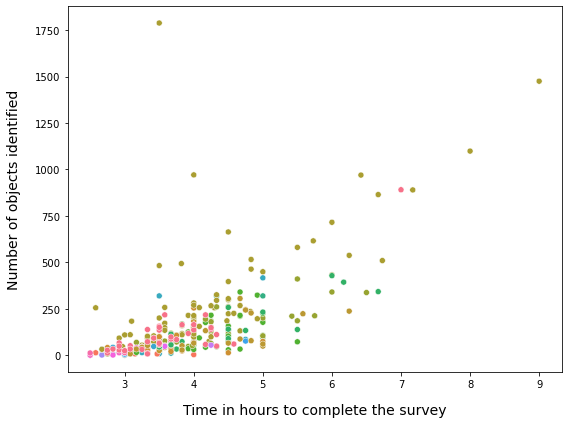

In [14]:
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(data=som_dims[som_dims.quantity != 'no data'], x='total_time', y='quantity', hue='water_name_slug', palette='husl', ax=ax)
ax.get_legend().remove()
ax.set_xlabel("Time in hours to complete the survey", **xlab_k14 )
ax.set_ylabel("Number of objects identified", **xlab_k14)
plt.tight_layout()
plt.show()

In [15]:
# create an intermediary group
# 
with open(F"{code_defs}/all_foams.json", "r") as a_file:
    foams_bg = json.load(a_file)
with open(F"{code_defs}/sheeting.json", "r") as a_file:
    sheeting_bg = json.load(a_file)
with open(F"{code_defs}/fragmented_plastics.json", "r") as a_file:
    fragplas_bg = json.load(a_file)

the_big_group = ['G27','G30', *foams_bg, *sheeting_bg, *fragplas_bg]

# map codes to descriptions to:
material_map = dfCodes.material
desc_map = dfCodes.description

# make an intermediary group
a_data['big_group'] = 'no group'
a_data.loc[a_data.code.isin(foams_bg), 'big_group'] = 'foams'
a_data.loc[a_data.code.isin(sheeting_bg), 'big_group'] = 'sheeting'
a_data.loc[a_data.code.isin(fragplas_bg), 'big_group'] = 'frag plastic'
a_data.loc[a_data.code.isin(['G27']), 'big_group'] = 'cigarette ends'
a_data.loc[a_data.code.isin(['G30']), 'big_group'] = 'snack wrapper'
for code in [x for x in a_data.code.unique() if x not in the_big_group]:
    a_data.loc[a_data.code==code, 'big_group'] = code


## <span style="color:#008891">The top ten objects identified</span>

In [16]:
# note all records where quantity is > 0
a_data['fail'] = a_data.quantity > 0
w_bassin_total = a_data.groupby('river_bassin').quantity.sum()

# get the list of codes by quantity
national_topten= a.code_totals.sort_values(ascending=False)

# take first ten records after sorting
national_topten_codes = national_topten.index[:10]

# grab the data from the survey results:
top_ten_national = a_data[a_data.code.isin(national_topten_codes)][['code', 'quantity', 'fail', 'pcs_m', 'loc_date']].copy()

# add descriptive and categorical variables:
top_ten_national['material'] = top_ten_national.code.map(lambda x: material_map.loc[x])
top_ten_national['description'] = top_ten_national.code.map(lambda x: desc_map.loc[x])


# agg the values from the survey data
# there is a convenience method for this
# the groups and the level where quantity is calculated:
groups = {'quantity_level':'code', 'columns':['code', 'description']}

# the columns to aggregate
aggs = {'pcs_m':'mean', 'quantity':'sum', 'fail':'sum', 'loc_date':'nunique'}

# columns divided by other columns
rates = [
    {'rate_name':'fail rate','columns':{'this':'fail', 'over_that':'loc_date'}},
    {'rate_name':'% of total', 'columns':{'this':'quantity', 'over_that':'feature_total'}},
]

# product of two columns
products = [
     {'rate_name':'rating', 'columns':{'this':'pcs_m', 'times_that':'fail rate'}}    
]

# method that returns the project total total:
def get_the_project_total(x , adf):
    return  adf.quantity.sum()

# calculate the fail rate and % of total for each code:
top_ten_agg = calculate_rates(top_ten_national, feature_total_map=get_the_project_total, feature_map=a_data,groups=groups, aggs=aggs, rates=rates, products=products)

# for display purposes make the description the index
top_ten_agg.set_index('description', inplace=True)
print(F"\nThe top ten objects are {round((top_ten_agg.quantity.sum()/num_obj)*100, 2)}% of all objects identified\n")

# print(F"\nthe top ten objects identified from all survey data, by quantity:\n\n")
tt_agg = top_ten_agg[['quantity']].sort_values(by='quantity', ascending=False).round(2)
tt_agg


The top ten objects are 59.44% of all objects identified



,quantity
description,
Cigarette butts and filters,7556
Foamed polystyrene pieces 0.5cm - 2.5cm,3627
Plastic pieces 0.5cm - 2.5cm,3447
"Food wrappers; candy, snack packaging",3086
Plastic pieces 2.5cm - 50cm,2894
Industrial sheeting,2388
"Glass or ceramic drink bottles, pieces",1828
Foam polystyrene; expanded beads/balls 2.5cm - 50cm,1717
Industrial pellets (nurdles),1664


#### <span style="color:#008891">Survey results: consolidating object categories</span>

The top ten list gives a very high level summary of the survey results. Based entirely on the total amount of an object found. It is a good indicator of overall abundance of an object in the ecosystem. Using this method we can account for ~60% of objects identified and very quickly identify the most abundant objects.

The top ten list can be improved to account for a greater percentage of the objects found. Currently, polystyrene is present in three forms in the top ten list, extruded polystyrene and two size variants of expanded polystyrene. Fragmented plastics are also present twice in the top ten list. The survey method was designed to get a maximum amount of detail for each survey. Grouping like objects by size is a common way to differentiate observations.

Some of the objects in the top ten list that can be consolidated:

1. There are three objects that are made from expanded or extruded polystyrene
2. Fragmented plastics are present in two different size ranges.

By combining like objects or objects that have the same or similar origin the impact of that group can be better appreciated. When the foam and the fragmented plastics are combined, that liberates three new places in the top ten list. Foams replace cigarette ends as the most abundant (pcs/m and quantity) but cigarette ends still retain the title as most frequently found (fail rate). The top ten list now accounts for ~70% of the objects identified.

#### <span style="color:#008891"> There is more room at the top: a consolidated top ten list</span>

In [17]:
fts = a_data.groupby(['river_bassin','big_group','loc_date'], as_index=False).agg({'pcs_m':'sum', 'quantity':'sum'})
fts['fail'] = fts.quantity > 0

# assign a description to results:

def assign_descriptions(x, **kwargs):
    if x in kwargs['exclude']:
        data = x
    else:
        data = kwargs['som_keys'][x]
    return data


groups = {'quantity_level':'big_group', 'columns':['big_group']}
# aggs = {'pcs_m':'mean', 'quantity':'sum', 'fail':'sum', 'loc_date':'nunique'}

ftsx = calculate_rates(fts, feature_total_map=get_the_project_total, feature_map=a_data,groups=groups, aggs=aggs, rates=rates, products=products)

bg_desc = ['foams', 'cigarette ends', 'frag plastic', 'snack wrapper', 'sheeting']
som_kwargs = dict(exclude=bg_desc, som_keys=desc_map)

ftsx['description'] = ftsx.big_group.map(lambda x: assign_descriptions(x, **som_kwargs))
#ftsx.drop('big_group', inplace=True)
ftsx = ftsx[['description','quantity', '% of total', 'pcs_m','fail rate']].set_index('description').sort_values(by='quantity', ascending=False)[:10].round(2)
print(F"\nThe consolidated top ten objects are {round((ftsx.quantity.sum()/num_obj)*100, 2)}% of all objects identified\n")
ftsx


The consolidated top ten objects are 67.72% of all objects identified



,quantity,% of total,pcs_m,fail rate
description,,,,
foams,8130,0.16,0.71,0.80
cigarette ends,7555,0.15,0.53,0.88
frag plastic,6341,0.13,0.52,0.87
snack wrapper,3085,0.06,0.25,0.86
sheeting,2387,0.05,0.20,0.71
"Glass or ceramic drink bottles, pieces",1828,0.04,0.16,0.65
Industrial pellets (nurdles),1664,0.03,0.13,0.33
Cotton bud/swab sticks,1324,0.03,0.11,0.52
Plastic construction waste,905,0.02,0.07,0.52


The *fail rate* is a **key indicator** as well as *% of total* and *pieces per meter*. Each indicator can be used to understand different aspects of the survey results. 

## <span style="color:#008891">Using the survey results: key indicators of the top ten objects</span>

### <span style="color:#008891">Key indicators for the most frequent questions:</span>

1. What do you find?
2. How often do you find it?
3. Do you find alot of it?
4. What else do you find?
5. Where do you find the most? 

The key indicators provide reasonable answwers to those questions using parameters that are taken directly from the survey data. The key indicators are used throughout the report. In this section we explain the key indicators and use them to answer some common questions about the national results.  There is a detailed example of each calculation in annex A.

### <span style="color:#008891">Key indicators definition and use</span>


#### **Fail rate:** How often at least one of a particular item was found at a survey

There are 76,466 observations from 346 surveys or 221 observations per survey. Observations that have a quantity greater than 0 for a survey are scored with a 1, if the quantity is 0 it is scored with a zero. The sum of the score is the number of times that an object was identified. 

_The fail rate is the number of times that an object was found divided by the number of samples taken._

__what does it mean:__ The fail rate describes how likely you are to find at least one of an object in the course of the survey

__how to use it:__ The objects with a high fail rate are those that are most likely to be found at a particular aggregation level

__Why is this important?__ The fail rate alerts us to the presence of items that are identified regularly even though they may not be found in large quantities or the inverse.
<br/><br />

#### **Pieces per meter:** How many objects were found within a defined distance

The pieces per meter ratio is the total number of objects found divided by the length in meters of the survey. This ratio is calculated for each record in the survey. Objects that were not identified durring a survey have a pcs/m ratio of 0.

_Pieces per meter is the number of objects found divided by the number of samples taken._

__what does it mean:__ The pcs-m ratio describes the average amount of an object you are likely to find if you mulitply pcs/m by the survey length

__how to use it:__ Objects with a high pcs/m ratio have a higher minimum value per survey (if they are found: see fail rate)

__Why is this is important?__ A high pcs/m ration indicates either proximity to a source or a zone of accumulation
<br/><br />

#### **% of total** The amount of an object relative to the other objects indeitififed

The percent of total describes the value of an object when all the other objects are considered.

__what does it mean:__ The % of total describes how much of the problem can be attributed to an object or group of objects

__how to use it:__ The % of total is the often the first indicator used to prioritize mitigation campaigns

__Why is this important:__ This helps define the problem at different levels
<br/><br />

#### <span style="color:#008891">Key indicators of the top ten objects for each river basin</span>

In [18]:
# define the groups and aggregationg level:
groups = {'quantity_level':'river_bassin', 'columns':['river_bassin', 'big_group']}
# get the remaining key indicators
rg_tt = calculate_rates(fts, feature_total_map=use_this_key, feature_map=w_bassin_total, groups=groups, aggs=aggs, rates=rates, products=products, methods=None)
rg_tt['description'] = rg_tt.big_group.map(lambda x: assign_descriptions(x, **som_kwargs))
rg_tt = rg_tt[rg_tt.description.isin(ftsx.index)]


# make heat map data
cols = ['description', 'river_bassin', '% of total']
columns = 'river_bassin'
index = 'description'
sort_values = 'aare'

rg_fr= make_heat_map_data(rg_tt, cols=cols, columns=columns, index=index, sort_values=sort_values)

cols = ['description', 'river_bassin', 'pcs_m']
columns = 'river_bassin'
index = 'description'
sort_values = 'aare'

# apply to data
rg_fpcs= make_heat_map_data(rg_tt, cols=cols, columns=columns, index=index)
rg_fpcs = rg_fpcs.reindex(rg_fr.index)
# define the map
cols = ['description', 'river_bassin', 'fail rate']
columns = 'river_bassin'
index = 'description'
sort_values = 'aare'

# apply to data
rg_fpct= make_heat_map_data(rg_tt, cols=cols, columns=columns, index=index)
rg_fpct = rg_fpct.reindex(rg_fr.index)

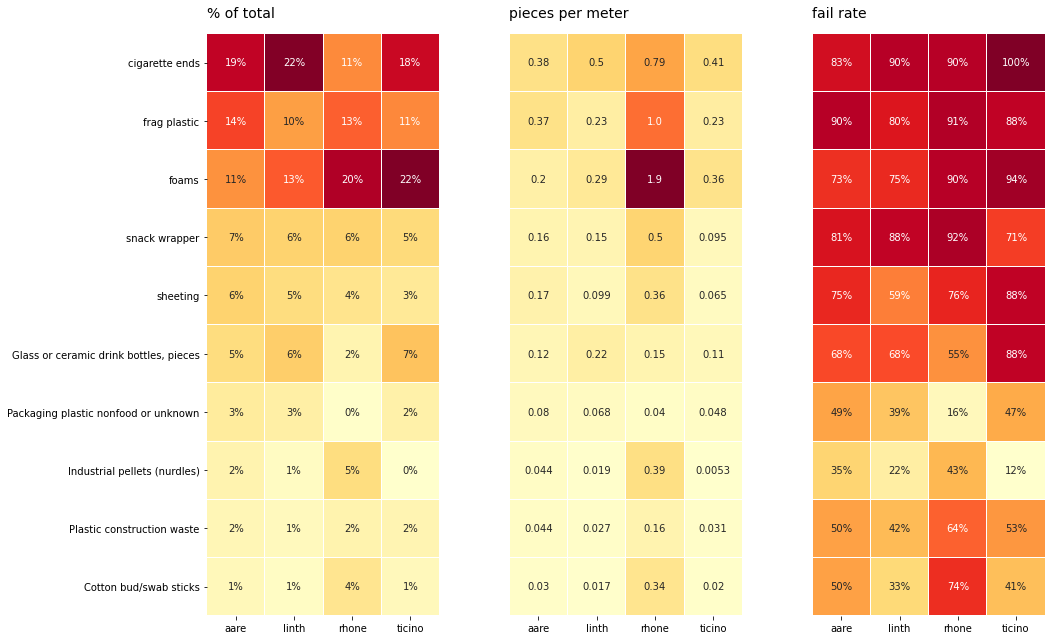

In [19]:
fig, axs = plt.subplots(1,3, figsize=(16,9))

sns.heatmap(rg_fr, ax = axs[0], cmap='YlOrRd', linewidth=.01, linecolor='white', annot=True, square=True, fmt=".0%", cbar=False)
sns.heatmap(rg_fpcs, ax = axs[1], cmap='YlOrRd', linewidth=.01, linecolor='white', annot=True, square=True, fmt=".2", yticklabels=False, cbar=False)
sns.heatmap(rg_fpct, ax = axs[2], cmap='YlOrRd', linewidth=.01, linecolor='white', annot=True, square=True, fmt=".0%", yticklabels=False, cbar=False)
axs[0].set_ylabel("")
axs[0].set_xlabel("", loc='left', labelpad=50)
axs[0].set_title("% of total", **title_k14)
axs[1].set_title("pieces per meter", **title_k14)
axs[2].set_title("fail rate", **title_k14)
axs[1].set_ylabel("")
axs[1].set_xlabel("")
axs[2].set_ylabel("")
axs[2].set_xlabel("")
plt.tight_layout()

plt.show()
plt.close()

#### <span style="color:#008891">Six object catgories make up ~55-65% of all the objects found</span>

This is true for all river bassins in the study. However, the relative amounts vary from one region to another: 

1. foam products: expanded polystyrene
2. cigarette ends
3. fragemented plastics
4. snack wrappers
5. industrial sheeting
6. glass or ceramic drink bottles

The fail rates for the first three objects in the consolidated top ten list remain conssistent accross the river basins surveyed. The difference between the highest and lowest values is no more than 17 for any of the top three and all have a fail rate betwen 77% and 100% depending on the river bassin.

After the first three objects the fail rate range increases for each object, up to 39% in the case of cotton swabs. Consider the fail rate of cotton swabs and GPI in the heat map below and compare that value to the values in the % of total chart above and the national results for the consolidated top ten.

#### <span style="color:#008891">Some objects are found regularly and from many locations others are found less frequently but at higher quantities</span>

The surveys results are cumulative values. Consider these two scenarios:

1. Objects are found regularly at **many locations** but at lower quantities than other objects
2. Objects are found regularly at **fewer locations** but at higher quantities than other objects

It is important to tell the difference between the two. The key indicators can help identify objects and locations that fit in to one of the two criteria. 

If an object was found regularly and in higher quantities than other objects (cigarette ends, foam etc...) it will place in the top ten list. The inverse is also true, if an object is found less often but in larger quantities relative to other objects it will also place in the top ten list.

#### <span style="color:#008891">Objects are found regulary but at lower quantities than other objects: cotton swabs</span>

Cotton swabs are a general purpose hygiene item that is commonplace in most households. GPI are a specialized product used in the manufacturing industry. In most cases cotton swabs are introduced into the river bassin by users flushing them down the toilet. GPI are introduced because of mishandling during transport or use.


An elevated fail rate is the key indicator for determining how often an object is found. Cotton swabs are found more often than GPI, both nationally and in all river bassins surveyed, but the % of total of GPI is greater nationally and in 3/4 of the river bassins surveyed (with the exception of Ticino).
An elevated fail rate is the key indicator for determining how often an object is found. Cotton swabs are found more often than GPI, both nationally and in all river bassins surveyed, but the % of total of GPI is greater nationally and in 3/4 of the river bassins surveyed (with the exception of Ticino).



NameError: name 'heat_map_data' is not defined

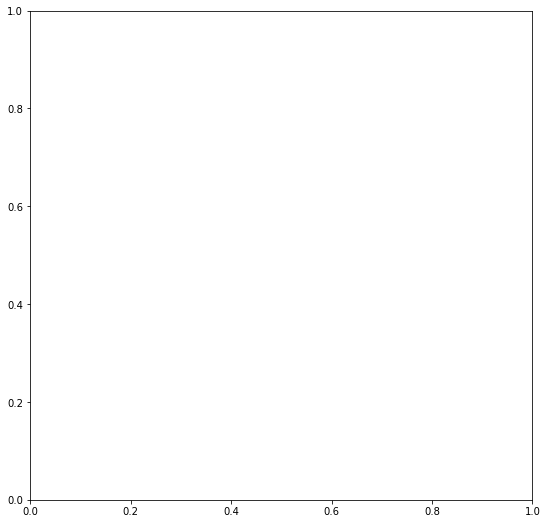

In [20]:
fig, ax = plt.subplots(figsize=(9,9))

sns.heatmap(data=heat_map_data, ax = ax, cmap='YlOrRd', linewidth=.01, linecolor='white', annot=True, square=True, fmt=".0%", cbar=False)

ax.set_ylabel("")
ax.set_xlabel("", loc='left', labelpad=50)
labels = [a_label.get_text().split('-') for a_label in ax.get_xticklabels()]
new_labels = [x[-1] for x in labels]
ax.set_xticklabels(new_labels)

plt.tight_layout()

plt.show()
plt.close()

In [ ]:
# make heat map data
# print(cc_feat_bg.columns)
heat_map_data = cc_feat_bg[['river_bassin', 'code', 'pcs_m']].pivot(index='code', columns='river_bassin').sort_values(by="code", ascending=False)

# flatten columns
heat_map_data.columns = heat_map_data.columns.get_level_values(1)

# apply the index order
heat_map_data = heat_map_data.reindex(index_order)

In [ ]:


fig, ax = plt.subplots(figsize=(9,9))

sns.heatmap(data=heat_map_data, ax = ax, cmap='YlOrRd', linewidth=.01, linecolor='white', annot=True, square=True, fmt=".2", cbar=False)

ax.set_ylabel("")
ax.set_xlabel("", loc='left', labelpad=50)
labels = [a_label.get_text().split('-') for a_label in ax.get_xticklabels()]
new_labels = [x[-1] for x in labels]
ax.set_xticklabels(new_labels)

plt.tight_layout()

plt.show()
plt.close()


### <span style="color:#008891">The major code groups</span>

The code groups were based on the objects found, the experience of surveyors and discussions with stakeholders from the federal government and NGOS with a long history of monitoring and removing trash from a variety of environments.

__What do code groups mean:__ They describe the __probable__ source activity of an object

__How to use them:__ Identify areas or zones of land use that encourage use of the object

__Why is this important:__ Helps identify sectors or groups that could benefit from outreach

### <span style="color:#008891">Key indicators of the major code groups</span>

Objects related to food consumption replace tobacco products and foams as the most abundant objects. Foams, folded into the construction category, are in 2nd followed by tobacco.

For these larger groups the pcs range (.003 - 0.2) is greater greater than the top ten list ( but the find rates for each group are more consolididated. is remains very similar to the 




In [ ]:
# calculate the fail rates at this aggregation level
group_fail_rates = a_data.groupby(['loc_date', 'groupname'], as_index=False).quantity.sum()
group_fail_rates['found'] = group_fail_rates.quantity > 0 
group_fail_rates = group_fail_rates.groupby('groupname').found.sum()

# make a group summary
group_summary = a_data.groupby('groupname').agg({'pcs_m':'mean', 'quantity':'sum',  'loc_date':'nunique'})
group_summary['found'] = group_summary.index.map(lambda x:group_fail_rates.loc[x] )
group_summary['find rate'] = group_summary.found/group_summary.loc_date
group_summary['% of total'] = group_summary.quantity/group_summary.quantity.sum()
group_summary = group_summary[['quantity', 'pcs_m', '% of total', 'find rate']].sort_values(by='quantity',ascending=False)


print("\nThis is the survey results aggregated to groupname for each survey, all locations:\n\n")
group_summary.round(3)

#### <span style="color:#008891"> Fail rate: how often the major code groups were indentified at each lake</span>

Compare the fail rate at the lake level to that of the national level.

In [ ]:
aggs = {'pcs_m':'sum', 'quantity':'sum'}
groups = {'quantity_level':'river_bassin', 'columns': ['river_bassin','loc_date', 'groupname']}


# def make_a_group_summary(adf, groups={}, aggs={}):
#     som_data = adf.groupby(groups['columns'], as_index=False).agg(aggs)
#     som_data['fail'] = som_data.quantity > 0
#     a_quantity = som_data.groupby(groups['quantity_level']).quantity.sum()
#     return som_data, a_quantity

feature_group_summary, a_quantity = make_a_group_summary(a_data, groups=groups, aggs=aggs)
# feature_group_summary

In [ ]:
# sum up failures, tries and quantity, get the mean value for pcs_m
aggs = {'pcs_m':'mean', 'quantity':'sum', 'loc_date':'nunique', 'fail':'sum'}
groups = {'quantity_level':'river_bassin', 'columns': ['river_bassin','groupname']}
rates = [
    {'rate_name':'fail rate','columns':{'this':'fail', 'over_that':'loc_date'}},
    {'rate_name':'% of total', 'columns':{'this':'quantity', 'over_that':'feature_total'}},
]

products = [
     {'rate_name':'rating', 'columns':{'this':'pcs_m', 'times_that':'fail rate'}}    
]

# def calculate_rates(adf, groups={}, aggs={}, rates={}, products={}):
#     fgs = adf.groupby(groups['columns'], as_index=False).agg(aggs)
#     fgs['feature_total'] = fgs[groups['quantity_level']].map(lambda x: a_quantity.loc[x])
#     for rate in rates:
#         fgs[rate['rate_name']] = fgs[rate['columns']['this']]/fgs[rate['columns']['over_that']]
#     for product in products:
#         fgs[product['rate_name']]= fgs[product['columns']['this']]*fgs[product['columns']['times_that']]
#     return fgs

fgs = calculate_rates(feature_group_summary, groups=groups, aggs=aggs, rates=rates)

fgs_rating = fgs[['river_bassin','groupname','% of total']].round(3).pivot(index='groupname', columns='river_bassin')
fgs_rating.columns = fgs_rating.columns.get_level_values(1)

In [ ]:
fig, ax = plt.subplots(figsize=(9,11))
sns.heatmap(data=fgs_rating, ax = ax, cmap='YlOrRd', linewidth=.01, linecolor='white', annot=True, square=True, fmt=".0%", cbar=False)

ax.set_ylabel("")
ax.set_xlabel("", loc='left', labelpad=50)
labels = [a_label.get_text().split('-') for a_label in ax.get_xticklabels()]
new_labels = [x[-1] for x in labels]
ax.set_xticklabels(new_labels)


plt.tight_layout()

plt.show()
plt.close()

#### <span style="color:#008891">Pieces per meter: the density of the major code groups for each lake</span>

Compare the fail rate at the lake level to that of the national level.

In [ ]:
# format for the heat map
fgs_rating = fgs[['river_bassin','groupname','pcs_m']].round(3).pivot(index='groupname', columns='river_bassin')
fgs_rating.columns = fgs_rating.columns.get_level_values(1)

fig, ax = plt.subplots(figsize=(9,11))
sns.heatmap(data=fgs_rating, ax = ax, cmap='YlOrRd', linewidth=.01, linecolor='white', annot=True, square=True, fmt=".2", cbar=False)

ax.set_ylabel("")
ax.set_xlabel("", loc='left', labelpad=50)
labels = [a_label.get_text().split('-') for a_label in ax.get_xticklabels()]
new_labels = [x[-1] for x in labels]
ax.set_xticklabels(new_labels)


plt.tight_layout()

plt.show()
plt.close()

#### <span style="color:#008891">The top ten results for each water feature</span>

In [ ]:
a_group_summary = a_data.groupby('groupname', as_index=False).agg({"quantity":"sum", "pcs_m":"mean"})
a_group_summary['% of total'] = a_group_summary.quantity/a_group_summary.quantity.sum()*100

a_group_summary.round(2)

## <span style="color:#008891">For the catchment area: assign code groups, regional labels and daily totals for survey data from the catchment area:</span>

In [ ]:
river_bassins['linth']

In [ ]:
dfBeaches['river_bassin']

In [ ]:
a_name='linth'
clas_kwargs = dict(
    code_group_data=group_names_locations,
    new_code_group=frag_plas,
    levels=['river_bassin', 'water_name_slug', 'city'],
    catchment_features = river_bassins[a_name],
    catchment_name=a_name,
    end_date=end_date,
    start_date=start_date,
    code_group_loc=output,
    catchment_cols=['river_bassin','water_name_slug','type','city','loc_date', 'location', 'date']
)



b = ac.CatchmentArea(a.processed, dfBeaches, **clas_kwargs)

In [ ]:
b.bassin_data[b.bassin_data.river_bassin == 'no data']

In [ ]:
for a_name in river_bassins:
    print(a_name)

In [ ]:
rbDfs = {}
for a_name in river_bassins:
    catchment_features = river_bassins[k]
    levels = ['river_bassin', 'water_name_slug', 'city']
    catchment_cols = ['river_bassin','water_name_slug','type','city','loc_date', 'location', 'date']
    catchment_name = a_name
    clas_kwargs.update({'catchement_featrures':catchment_features, 'levels':levels, "catchment_cols":catchment_cols,"catchment_name":catchment_name})
    rbDfs.update({a_name:ac.CatchmentArea(a.processed, dfBeaches, **clas_kwargs)})

In [ ]:
rbDfs['ticino'].bassin_data

In [ ]:
som_bassin_data = b.bassin_data.copy()

# mark all the records that have quantity > 0
som_bassin_data['fail'] = som_bassin_data.quantity > 0
som_bassin_data = som_bassin_data[som_bassin_data.columns[1:]]
print(F"\nThe columns from the survey data:\n\n{som_bassin_data.columns}\n")

#### <span style="color:#008891">Get the dimensional data for the catchment area:</span>

### <span style="color:#008891"> Get sample rates at the code level:</span>

In [ ]:
# map number of samples per location and sample total to each record

def add_attribute(x, a_map={}):
    try:
        num_samps = a_map[x]
    except:
        num_samps = 0
    return num_samps

# conut the number of samples per location
num_samp_location = b.bassin_pcsm_day.groupby('location').loc_date.count()

# retrieve the total quantity per sample
qty_sample = b.bassin_pcsm_day.groupby('loc_date').quantity.sum()

In [ ]:
# map values to bassin data

# the number of samples at a location
for beach in som_bassin_data.location.unique():
    som_bassin_data.loc[som_bassin_data.location==beach, 'nsamps'] = add_attribute(beach, a_map=num_samp_location)

# the number of samples at a location divided by the total number of samples
# som_bassin_data['l_weight'] = som_bassin_data.nsamps/len(som_bassin_data.loc_date.unique())

# the survey total for the corresponding loc_date variable
for loc_date in som_bassin_data.loc_date.unique():
    som_bassin_data.loc[som_bassin_data.loc_date==loc_date, 'samp_total'] = qty_sample[[loc_date]][0]

# the % of total for that object for the survey defined by loc_date
som_bassin_data['sample_% _of_total'] = som_bassin_data.quantity/som_bassin_data.samp_total

In [ ]:
def save_describe(x):
    data=x.describe()
    return data.values

# save the key values from the original data:
q_before = save_describe(som_bassin_data.quantity)
pc_befor = save_describe(som_bassin_data.pcs_m)
print(som_bassin_data.quantity.sum())

In [ ]:
# rank the quantity found of each code in each survey for all locations
ranked = []

# the loc_date values to aggregate:
locs = som_bassin_data.loc_date.unique()

# for each value in loc_date:
sbd = som_bassin_data.copy()
for a_samp in locs:
    # sort the values for each survey by 
    sbdl = sbd[sbd.loc_date == a_samp].sort_values(by='quantity', ascending=False)
    sbdl = sbdl.set_index(np.arange(1, len(sbdl)+1), drop=True)
    sbdl['sample_rank'] = sbdl.index
    ranked.append(sbdl)
    
# new data with amplitude rankings for each record
sbd = pd.concat(ranked, ignore_index=True)

# check the key values before and after:
print(q_before == sbd.quantity.describe().values)
print(sbd.quantity.sum())
print(pc_befor == sbd.pcs_m.describe().values)


In [ ]:
sbd.columns

In [ ]:
sbd.head()

In [ ]:
# the top ten for the catchment area:
catchment_top_ten = sbd.groupby('code').quantity.sum().sort_values(ascending=False)
print(F"\n objects grouped by code and sorted by quantity found:\n\n{catchment_top_ten[:10]}\n")

In [ ]:
print("\n objects grouped by code and sorted by median pcs-m: \n\n")
sbd[sbd.quantity > 0].groupby(['code']).pcs_m.median().sort_values(ascending=False)[:10]

In [ ]:
print("\n objects grouped by code and sorted by quantity found: \n\n")
sbd[sbd.quantity > 0].groupby(['code']).quantity.sum().sort_values(ascending=False)[:10]

In [ ]:
print("\n objects grouped by code and sorted by number of times at least one was found: \n\n")
sbd[sbd.quantity > 0].groupby(['code']).fail.sum().sort_values(ascending=False)[:10]

### Sample rank: how much of the sample total was taken up by this object analogous to % of sample total

In [ ]:
print("\n objects grouped by water feature and code, sorted by frequency of sample ranking: \n\n")
sbd[sbd.quantity > 0].groupby(['water_name_slug','code', 'sample_rank'], as_index=False).loc_date.nunique().sort_values(by='loc_date', ascending=False)

In [ ]:
print("\n objects grouped by water feature and code, sorted by quantity found: \n\n")
sbd[sbd.quantity > 0].groupby(['water_name_slug','code'], as_index=False).quantity.sum().sort_values(by='quantity', ascending=False)

In [ ]:
print("\n objects grouped by water feature and code, sorted by median pcs_m: \n\n")
sbd[sbd.quantity > 0].groupby(['water_name_slug','code'], as_index=False).pcs_m.median().sort_values(by='pcs_m', ascending=False)

### Get sample rates at the group level:

In [ ]:
def calculate_fail(x):
    a_q = x.sum()
    if a_q > 0:
        data = True
    else:
        data = False
    return data

In [ ]:
sbd_g = sbd.groupby(['water_name_slug', 'type', 'loc_date', 'date', 'location', 'groupname', 'nsamps', 'samp_total'], as_index=False).agg({'quantity':'sum', 'pcs_m':'sum', 'fail':calculate_fail})

sbd_g_ranked = []
for a_samp in locs:
    # sort the values for each survey by 
    sbdl = sbd_g.loc[sbd_g.loc_date==a_samp].sort_values(by='quantity', ascending=False)
    sbdl = sbdl.set_index(np.arange(1, len(sbdl)+1), drop=True)
    sbdl['sample_rank'] = sbdl.index
    sbd_g_ranked.append(sbdl)
sbd_g_ranked[0]
sbd_gr = pd.concat(sbd_g_ranked, ignore_index=True)
sbd_gr.head()

In [ ]:
fd = sbd_gr[(sbd_gr.water_name_slug=='Bielersee')&(sbd_gr.sample_rank==1)].groupby('groupname').sample_rank.sum()
fd.sum()
print(fd)

In [ ]:
sbd_gr[sbd_gr.water_name_slug == 'Aare'].groupby(['water_name_slug','groupname', 'sample_rank'], as_index=False).loc_date.nunique()

In [ ]:
other_number_one_ranks = rank_and_code[rank_and_code['rank'] == 1].groupby(['code','location'], as_index=False).n_times.sum()
print(F"Codes and the number of times that they have been the number one item at a survey\n{other_number_one_ranks.groupby('code').n_times.sum().sort_values(ascending=False)}")

In [ ]:
# project directory is 'output/bielsummary'
sbd_ranked.to_csv(F"{project_directory}/aare_codes_ranked.csv")

In [ ]:
these_codes = ['G27', 'G30','G25', 'G81', 'G95', 'G67','G82']

In [ ]:
# grouped by survey and code group
sbd_ranked_gs = som_bassin_data.groupby(['loc_date','groupname','location', 'population'], as_index=False).agg({'pcs_m':'sum', 'quantity':'sum'})

sbd_ranked_gs['% of total'] = sbd_ranked_gs.apply(lambda x: x.quantity/qty_sample[x.loc_date], axis=1)
# save the key values from the original data:
q_before = save_describe(sbd_ranked_gs.quantity)
pc_befor = save_describe(sbd_ranked_gs.pcs_m)
print(sbd_ranked_gs.quantity.sum())

In [ ]:
ranked = []
for a_samp in locs:
    sbdl = sbd_ranked_gs[sbd_ranked_gs.loc_date == a_samp].sort_values(by='% of total', ascending=False)
    sbdl = sbdl.set_index(np.arange(1, len(sbdl)+1), drop=True)
    sbdl['rank'] = sbdl.index
    ranked.append(sbdl)
    
sbd_ranked_gs = pd.concat(ranked, ignore_index=True)

# check the key values before and after:
print("Check that the survey values have not been altered:\n")
print(q_before == sbd_ranked_gs.quantity.describe().values)
print(pc_befor == sbd_ranked_gs.pcs_m.describe().values)

# check the % of total
print(F"\nCheck % of total: {sbd_ranked_gs.groupby('loc_date')['% of total'].sum().sum()}\n")
print(F"The number of SURVEYS where ALL TOBACCO items combined are rank one: {sbd_ranked_gs[(sbd_ranked_gs.groupname == 'tobacco')&(sbd_ranked_gs['rank'] == 1)].loc_date.nunique()}\n")

print(F"All TOBACCO items combined were number one in {np.round((sbd_ranked_gs[(sbd_ranked_gs.groupname == 'tobacco')&(sbd_ranked_gs['rank'] == 1)].loc_date.nunique()/sbd_ranked_gs.loc_date.nunique())*100,0)}% of the surveys.")
print(F"\nThe number of locations that tobaco is rank one: {sbd_ranked_gs[(sbd_ranked_gs.groupname == 'tobacco')&(sbd_ranked_gs['rank'] == 1)].location.nunique()}\n")
print(F"The objects labeled tobacco:\n{sbd_ranked[sbd_ranked.groupname == 'tobacco'].code.unique()}")

In [ ]:
f = sbd_ranked_gs.groupby(['rank','groupname','location'], as_index=False).loc_date.nunique()
fx = f[f['rank'] == 1].groupby('groupname').loc_date.sum()
print(F"\nThe number of samples: {fx.sum()}\n")
print(F"Other groups and the number of times they have been the most prevalent item:\n{fx.sort_values(ascending=False)}\n")

In [ ]:
# get the pass fail rate for each water feature

# the total number of tries:
tries_t = som_bassin_data.groupby(['water_name_slug', 'code']).loc_date.nunique()

# the total number of times that the object was found for a particular water feature
fails_b = som_bassin_data.groupby(['water_name_slug','code']).fail.sum()

# the total number of samples:
n_samps_b = som_bassin_data.groupby(['water_name_slug']).loc_date.nunique()

In [ ]:
# get all values greater than zero for each code and LOCATION
grtr_than_zero = som_bassin_data[(som_bassin_data.quantity > 0)].groupby(['code', 'location'], as_index=False).loc_date.count()

# weight the result by the sum of the loc_date column
grtr_than_zero['weight'] = grtr_than_zero.loc_date/grtr_than_zero.loc_date.sum()

# housekeeping
som_data = som_bassin_data.copy()

# get a list of the codes that were found at least once
codes_in_use = grtr_than_zero.code.unique()

In [ ]:
# combine the tries and fails dfs for each water feature
tries_fails_b = pd.concat([tries_t, fails_b], axis=1)
tries_fails_b.reset_index(inplace=True)

In [ ]:
tries_fails_b.iloc[:3]

In [ ]:
# get the ratio of total tries per code and location to total number of samples for that feature
for a_b in tries_fails_b.water_name_slug.unique():
    tries_fails_b.loc[tries_fails_b.water_name_slug==a_b, 'rate'] = tries_fails_b.fail/n_samps_b.loc[a_b]

tries_fails_b.iloc[:3]

In [ ]:
# the minimum rate is 1/ the current sample number + 1
# we are assuming that if the object has never been found before there
# is always a chance that we may find it on the next sample
# the longer we go without finding it the less likely it is to find in the river basin
# which means that once it has been identified this should be considered a significant event.
rate_min = 1/(len(a.processed.loc_date.unique())+1)
rate_min

In [ ]:
tries_fails_b.loc[tries_fails_b.fail==0, 'min_rate'] = rate_min
tries_fails_b.loc[tries_fails_b.fail>0, 'min_rate'] = tries_fails_b.rate
tries_fails_b.iloc[:3]

In [ ]:
# get the ratio samples-per-location/number-samples-catchment-area
weights = tries_fails_b[['water_name_slug', 'loc_date']].drop_duplicates().set_index('water_name_slug', drop=True)
weights['location_weight'] = weights.loc_date/len(locs)
nsamps = weights.loc['Aare', :]

# now the number of samples and the weight is available
nsamps

In [ ]:
# pull some samples from one river basin feature
feature = 'Aare'
n = weights.loc['Aare', 'loc_date']
rates = tries_fails_b.loc[tries_fails_b.water_name_slug == 'Aare'][['code','min_rate']].set_index('code')

# store the samples here
theta_samples_feature = pd.DataFrame(index=codes_in_use)

In [ ]:
rates.loc['G27'].values

In [ ]:
# determine wehter or not an object was found at a survey
# use the rates for the parameter of a bernouli trial for each code

k=0
for j in np.arange(n):
    k+=1
    col_name = F"s_{int(k)}"
    for a_code in codes_in_use:
        theta_samples_feature.loc[a_code, col_name ] = bernoulli.rvs(rates.loc[a_code], size=1)


found_feature = theta_samples_feature > 0
codes_found_feature = [found_feature[found_feature[s_one] == True][s_one].index for s_one in found_feature.columns]
codes_found_len_feature = [len(x) for x in codes_found_feature]

In [ ]:
d_samps_aare = b.bassin_data[(b.bassin_data.quantity>0)&(b.bassin_data.water_name_slug == "Aare")][['loc_date', 'code']].groupby('loc_date').code.unique().to_numpy()

In [ ]:
# get the number of times each code was found
def count_occurences(an_array):
    wiw = {}
    for a_list in an_array:
        for code in a_list:
            if code in wiw.keys():
                wiw[code] += 1
            else:
                wiw[code] = 1
    return [{'code':k, 'inst':v} for k,v in wiw.items()]
theta_codes_count = count_occurences(codes_found_feature)
dsamp_aare_count = pd.DataFrame(count_occurences(d_samps_aare)).set_index('code')

In [ ]:
dsamp_aare_count.loc['G7', 'inst']

In [ ]:
# combine the counts in to one dataframe and compare results

def combine_code_counts(x):
    try:
        data = dsamp_aare_count.loc[x, 'inst']
    except:
        data = 0
    return data
        
theta_codes = pd.DataFrame(theta_codes_count)
theta_codes['s_inst'] = theta_codes.code.map(lambda x: combine_code_counts(x))
theta_codes['inst_dif'] = theta_codes.inst - theta_codes.s_inst

# check the diffference between the two sets
print(theta_codes['s_inst'].sum())
print(theta_codes['inst'].sum())
print(theta_codes.inst_dif.sum())
print(len(theta_codes))

In [ ]:
theta_codes[theta_codes.code.isin([x for x in theta_codes.code.unique() if x not in dsamp_aare_count.index])]

In [ ]:
fig, axs = plt.subplots(2,1, figsize=(12,8))
sns.barplot(data=theta_codes.sort_values(by='s_inst', ascending=False), x='code', y='s_inst', ax=axs[0])
sns.barplot(data=theta_codes.sort_values(by='inst', ascending=False), x='code', y='inst', ax=axs[1])
axs[0].tick_params(axis='x', labelrotation=90, labelsize=8)
axs[1].tick_params(axis='x', labelrotation=90, labelsize=8)
plt.show()
plt.close()

In [ ]:
theta_samples_all = pd.DataFrame(index=codes_in_use)
tries = som_bassin_data.groupby(['code']).loc_date.nunique()
fails = som_bassin_data.groupby('code').fail.sum()
# tries_fails by water body

# for one body of water
#fails_b = som_bassin_data.groupby(['water_name_slug','code']).fail.sum()

tries_fails = pd.concat([tries, fails], axis=1)
tries_fails['rate'] = tries_fails.fail/tries_fails.loc_date

code_weights = grtr_than_zero.groupby('code').weight.sum()

In [ ]:
k = 0
for body in weights.index:
#     print(body)
#     print(tries_fails_b.loc[body].min_rate.sum())
    these_rates =tries_fails_b.loc[tries_fails_b.water_name_slug == body][['code','min_rate']].set_index('code')
    

    for j in np.arange(weights.loc[body]['loc_date']):
        k+=1
        #print(j, k)
        col_name = F"s_{int(k)} {body}"
        for a_code in codes_in_use:
            theta_samples_all.loc[a_code, col_name ] = bernoulli.rvs(these_rates.loc[a_code], size=1)
#             theta_samples_all.loc[a_code, col_name ] = binom.rvs(1,these_rates.loc[a_code], size=1)
            

In [ ]:
found = theta_samples_all > 0
codes_found = [found[found[s_one] == True][s_one].index for s_one in found.columns]
codes_found_len = [len(x) for x in codes_found]

print(len(codes_found[0]))
print(codes_found_len[0])
print(len(codes_found))

In [ ]:
tries_fails.iloc[:3]

In [ ]:
# the number of unique codes per sample in the project data:
d_samps = b.bassin_data[b.bassin_data.quantity>0][['loc_date', 'code']].groupby('loc_date').code.nunique()

# the list of codes found at each survey in the project data:
d_samps_c = b.bassin_data[b.bassin_data.quantity>0][['loc_date', 'code']].groupby('loc_date').code.unique().to_numpy()

In [ ]:
def count_occurences(an_array):
    wiw = {}
    for a_list in an_array:
        for code in a_list:
            if code in wiw.keys():
                wiw[code] += 1
            else:
                wiw[code] = 1
    return [{'code':k, 'inst':v} for k,v in wiw.items()]
samp_codes = pd.DataFrame(count_occurences(d_samps_c)).set_index('code')


In [ ]:
# a_list_o_list = [value for k, value in samples.items()]
# the_list_o_list = [*a_list_o_list]
theta_codes = pd.DataFrame(count_occurences(codes_found))
theta_codes['s_inst'] = theta_codes.code.map(lambda x: samp_codes.loc[x, 'inst'])
theta_codes['inst_dif'] = theta_codes.inst - theta_codes.s_inst

In [ ]:
print(theta_codes['inst_dif'].sum())
print(len(theta_codes))
print(theta_codes.inst.sum(), theta_codes.s_inst.sum())

In [ ]:
fig, axs = plt.subplots(figsize=(18,8))
sns.barplot(data=theta_codes[theta_codes.inst >=20].sort_values(by='s_inst', ascending=False), x='code', y='s_inst', color='red', alpha=.6, ax=axs)
sns.barplot(data=theta_codes[theta_codes.inst >=20].sort_values(by='inst', ascending=False), x='code', y='inst', color='blue',alpha=.6, ax=axs)
axs.tick_params(axis='x', labelrotation=90, labelsize=10)
# axs[1].tick_params(axis='x', labelrotation=90, labelsize=8)
plt.show()
plt.close()

In [ ]:

fig, axs = plt.subplots(1,2)
sns.histplot(codes_found_len, ax=axs[0], binwidth=3)
sns.histplot(d_samps.values, ax=axs[1], binwidth=3)
plt.show()
plt.close()

In [ ]:
# found.rename(columns={x:x.split(" ")[-1] for x in found.columns}, inplace=True)
codes_found = [{'label':s_one.split(" ")[-1] , 'codes':found[found[s_one] == True][s_one].index.to_numpy()} for s_one in found.columns]
# codes_found_len = [len(x) for x in codes_found_feature]
a_label = codes_found[1]['label']
a_code = codes_found[1]['codes'][0]

In [ ]:
location_weight = som_bassin_data.groupby('water_name_slug', as_index=False).l_weight.median()
location_weight.loc[4, 'water_name_slug'] = "Thièle"

In [ ]:
agg_results_feature = som_bassin_data[som_bassin_data.pcs_m > 0].groupby(['water_name_slug','code']).agg({'pcs_m':['mean', 'min', 'median', 'max']})
agg_results_feature.columns = agg_results_feature.columns.get_level_values(1)
agg_results_bassin = som_bassin_data[som_bassin_data.pcs_m > 0].groupby(['code']).agg({'pcs_m':['mean', 'min', 'median', 'max']})
agg_results_bassin.columns = agg_results_bassin.columns.get_level_values(1)
# get the parameters for one code at one sample:
this_data = agg_results_feature.loc[a_label,codes_found[1]['codes'][0]]
print(this_data['mean'])
print(codes_found[1]['codes'][0])
print(a_label)
loc = this_data['mean']
alpha=this_data['min']
beta = 1/alpha
print("\n the parameters \n")
print(loc, alpha, beta)

print("\nthe predicted result \n")
print(gamma.rvs(alpha, loc=loc, scale=beta))

In [ ]:
agg_results_feature.loc['Aare','G101']['min']

In [ ]:
# hmm = pd.DataFrame(codes_found).explode('codes').copy()
# hmm.drop_duplicates(inplace=True)
# print(hmm.isnull().values.any())
# hmm.reset_index(inplace=True, drop=True)

In [ ]:
def assign_params(a_label, a_code, a_param, params):
    default_params = agg_results_bassin
    try:
        this_param = params.loc[a_label,a_code][a_param]
    except:
        this_param = default_params.loc[a_code][a_param]
    return this_param
    

In [ ]:
o_samps_d = b.bassin_pcsm_day[['water_name_slug', 'pcs_m']].sort_values(by='pcs_m')
o_samps_d.reset_index(inplace=True, drop=True)
o_samps_d

In [ ]:
location_weight.set_index('water_name_slug', drop=True, inplace=True)


In [ ]:
location_weight

In [ ]:
sim_surveys = []
for i,sample in enumerate(codes_found):
    a_label = sample['label']
    som_codes = sample['codes']
    loc_weight = location_weight.loc[a_label]
    for a_code in som_codes:
        alpha = assign_params(a_label, a_code, 'median', agg_results_feature)
        loc = assign_params(a_label, a_code, 'min', agg_results_feature)
        scale = assign_params(a_label, a_code, 'max', agg_results_feature)+(5*alpha)       
        pcs_m = gamma.rvs(alpha+(loc_weight*alpha), loc=loc, scale=scale)
        sim_surveys.append({'code':a_code, 'label':a_label, 'survey':i, 'pcs_m':pcs_m})
    
new_surveys = pd.DataFrame(sim_surveys)
new_surveys_d = new_surveys.groupby(['survey','label'], as_index=False).pcs_m.sum().copy()

new_surveys_d.sort_values(by='pcs_m', inplace=True)
ns_d = new_surveys_d[['label', 'pcs_m']].reset_index(drop=True).copy()
ns_d.rename(columns={'label':'water_name_slug'}, inplace=True)
ns_d['label'] = 'sim'
o_samps_d['label'] = 'odata'
o_samps_d['survey'] = o_samps_d.index
ns_d['survey'] =ns_d.index

In [ ]:
o_samps_d['label'] = 'odata'

combined = pd.concat([ns_d, o_samps_d])

In [ ]:
combined

In [ ]:
fig, axs = plt.subplots(figsize=(14,8))
sns.scatterplot(data=combined, x='survey', y='pcs_m', style='label', hue='water_name_slug', palette='husl', s=40, ax=axs)
# sns.scatterplot(data=o_samps_d, x=o_samps_d.index, y=o_samps_d.pcs_m, hue=o_samps_d.water_name_slug, palette='viridis', ax=axs)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()

In [ ]:
# get the values for one survey:
fig, axs = plt.subplots(figsize=(14,8))
sns.boxplot(data=combined, x='water_name_slug', y='pcs_m', hue='label', palette='flare', ax=axs, dodge=True)
sns.stripplot(data=combined, x='water_name_slug', y='pcs_m', hue='label', palette='husl', ax=axs)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()


In [ ]:
hmm

In [ ]:
these_params = []

# get some paramaters from the data.
print("The codes and the number of samples that the parameters are being drawn from\n")
for code in samples[0]:
    samp_data = som_params[som_params.code == code].pcs_m
    # check how many samples there are for this region/district
    # if less than minsamps grab the results from the next highest level
    minsamps = 65
    if len(samp_data) < minsamps:
        samp_data = a.processed[(a.processed.code == code)&(a.processed.quantity > 0)].pcs_m
        loc = samp_data.min()
        alpha = samp_data.mean()
        scale = 1/alpha
    else:
        loc = samp_data.min()
        alpha = samp_data.mean()
        scale = 1/alpha
    print(code, len(samp_data))
    these_params.append(dict(code=code, loc=loc, alpha=alpha, scale=scale, data=samp_data))


In [ ]:
these_params[2]['data'].sum()

#### Hopefully that just worked for you

if not contact analyst@hammerdirt.ch